In [11]:
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt

In [12]:
# import my modules:
import sys
sys.path.append('../src')
import joa_helpers as hlp
import importlib
importlib.reload(hlp);

In [13]:
np.random.seed(42)

# datapath="/media/ssd2/RESULTS-reverb-match-cond-u-net/"
datapath="/home/ubuntu/Data/"

In [14]:
# # ---------- NOISE POOL ------------
# # create df with paths to noise files 
# noise_path=pjoin(datapath,'wham')
# database="wham"
# noise_pool = []
# for split in ['tr', 'cv', 'tt']:
#     split_path = pjoin(pjoin(noise_path, 'wham_noise'), split)
#     for audio_path in os.listdir(split_path):
#         noise_pool.append({'database_noise': database, 'noise_file_path': pjoin(split_path,audio_path)})

# noise_pool=pd.DataFrame(noise_pool)
# print(f"{len(noise_pool)=}")

# noise_pool.to_csv("noise_pool.csv")
# noise_pool.head(10)

In [15]:
# ---------- SPEECH POOL ------------

# create df with paths to speech files
speech_dataset_path1 =  pjoin(datapath,'VCTK','wav48_silence_trimmed')
speech_dataset_path2 =  pjoin(datapath,'LibriMix','LibriSpeech')
speech_dataset_path3 =  pjoin(datapath,'PTDB')

# initialize empty list of files:
speech_pool = []

# fill the list of files with filenames from vctk data base:
database="VCTK"
for root, dirs, files in os.walk(speech_dataset_path1):
    for file in files:
        if file.endswith('.flac'):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# # fill the list of files with filenames from librispeech data base:
# database="librispeech"
# for split in ['train-clean-100', 'test-clean', 'dev-clean']:
#     split_path = pjoin(pjoin(speech_dataset_path2, split))
#     for root, dirs, files in os.walk(split_path):
#         for file in files:
#             if file.endswith('.flac'):
#                 speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# fill the list of files with filenames from ptdb data base:
database="PTDB"
for root, dirs, files in os.walk(speech_dataset_path3):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if ("/MIC/" in root) & (file.endswith('.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  

# shuffle order
random.shuffle(speech_pool)

# turn list to data frame 
speech_pool = pd.DataFrame(speech_pool)
print(f"{len(speech_pool)=}")


len(speech_pool)=93046


In [16]:
# ---------- RIR POOL ------------
rir_path=pjoin(datapath,'synth_rirs_mono')

database="synth_rirs_mono"
# load df with rirs paths and stats:
rir_pool=pd.read_csv(pjoin(rir_path,"rir_info.csv"),index_col=0)
rir_pool["database_rir"]=database
print(f"{len(rir_pool)=}")
rir_pool.to_csv("rir_pool.csv")
rir_pool.head(10)

len(rir_pool)=10000


,room_x,room_y,room_z,volume,rt60_set,mic_pos_x,mic_pos_y,mic_pos_z,src_pos_x,src_pos_y,...,rt60_true,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir
0,3.087404,1.733557,2.544188,13.616981,0.094051,1.275112,0.636568,1.717796,1.375112,0.636568,...,0.094054,0.094054,0.678853,1.545836,0.087845,0.090524,0.222644,29.869119,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x309...,synth_rirs_mono
1,3.120417,1.627469,2.705770,13.740938,0.098842,1.533229,0.775045,1.112430,1.633229,0.775045,...,0.098846,0.098838,0.665230,1.533153,0.108747,0.107866,0.212617,25.080770,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x312...,synth_rirs_mono
2,3.061378,1.560564,3.018367,14.420179,0.096717,1.878979,0.702089,1.150549,1.978979,0.702089,...,0.096723,0.096712,0.688923,1.539943,0.096810,0.093025,0.235392,26.606241,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x306...,synth_rirs_mono
3,3.076184,1.544429,3.316970,15.758751,0.094286,1.419961,0.712446,1.134668,1.519961,0.712446,...,0.094291,0.094282,0.729411,1.569801,0.087765,0.089848,0.230418,27.731729,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x308...,synth_rirs_mono
4,3.015096,1.828398,3.086247,17.013851,0.100507,1.599783,0.966029,1.815395,1.699783,0.966029,...,0.100508,0.100506,0.734059,1.663050,0.099996,0.100491,0.220712,28.897935,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x302...,synth_rirs_mono
5,3.079932,1.645339,3.434983,17.406880,0.107771,1.097511,0.717791,1.034888,1.197511,0.717791,...,0.107776,0.107776,0.717009,1.634545,0.106246,0.109946,0.233664,22.603079,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x308...,synth_rirs_mono
6,3.478583,1.810856,2.799080,17.632004,0.096148,2.047192,0.964826,1.030445,2.147192,0.964826,...,0.096153,0.096144,0.764039,1.670902,0.093377,0.096400,0.196960,28.776429,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x348...,synth_rirs_mono
7,3.222587,1.953429,2.803276,17.646888,0.103874,1.995593,1.066677,1.723879,2.095593,1.066677,...,0.103878,0.103869,0.735387,1.696417,0.099488,0.097691,0.225181,26.747138,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x322...,synth_rirs_mono
8,3.094981,1.597018,3.713484,18.354788,0.092483,1.948308,0.915701,1.922755,2.048308,0.915701,...,0.092484,0.092484,0.794817,1.641282,0.088072,0.092394,0.212735,28.558985,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x309...,synth_rirs_mono
9,3.136293,1.779292,3.310702,18.474978,0.093152,1.900544,0.934894,1.239519,2.000544,0.934894,...,0.093153,0.093153,0.794544,1.690732,0.082575,0.086574,0.208506,32.160277,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x314...,synth_rirs_mono


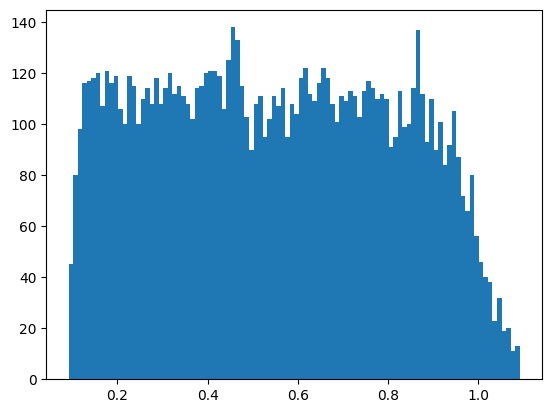

In [17]:
plt.hist(rir_pool["rt60_set"], bins=100)
plt.show()

In [19]:
# --------- CREATE METADATA FOR A DATASET BEING COMBINATIONS OF SPEECH, NOISE AND RIRS --------
from datetime import datetime
date_tag = datetime.now().strftime("%d-%m-%Y--%H-%M")
# create dataset with 20000 data points, which consists of random combinations of speech, noise and rirs
N_datapoints=150000

# # sample from noise pool: 
# df_noise=noise_pool.sample(N_datapoints,replace=True)
# # here plan ways to augment noise data set:
# random_bool_values = [random.choice([1, -1]) for _ in range(len(df_noise))]
# df_noise["aug_phase"]=random_bool_values

# sample from speech pool: 
df_speech=speech_pool.sample(N_datapoints,replace=True)
# here plan ways to augment noise data set:
random_bool_values = [random.choice([1, -1]) for _ in range(len(df_speech))]
df_speech["aug_phase"]=random_bool_values

# sample from rir pool: 
df_rir=rir_pool.sample(N_datapoints,replace=True)

# concatenate samples from speech, noise and rir pools
# df_ds = pd.concat([df_speech.reset_index(drop=True), df_noise.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)
df_ds = pd.concat([df_speech.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)

df_ds = df_ds.reset_index(drop=True)

# randomize snr (only high snrs)
# df_ds["snr"]= 200 #np.random.uniform(low=10, high=30, size=len(df_ds))

# Create test-train-val split:
df_ds.loc[0:N_datapoints*0.8,"split"]="train" # 80% training data
df_ds.loc[N_datapoints*0.8:N_datapoints*0.9,"split"]="test" # 10% testing data
df_ds.loc[N_datapoints*0.9:N_datapoints,"split"]="val" # 10% validation data

df_ds.to_csv(date_tag+"_data_set.csv")


In [20]:
# # Change paths in the metadata from GuestXR computer: 

# df = pd.read_csv("../dataset-metadata/nonoise2_guestxr2.csv",index_col=0)

# df["speech_file_path"]=df["speech_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["noise_file_path"]=df["noise_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["ir_file_path"]=df["ir_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")

# df.to_csv("../dataset-metadata/nonoise2_dacom.csv",index=False)

# df.head(10)

In [3]:
# # Change paths in the metadata from GuestXR computer: 

# df = pd.read_csv("../dataset-metadata/check_data_set.csv",index_col=0)

# df["speech_file_path"]=df["speech_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["noise_file_path"]=df["noise_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["ir_file_path"]=df["ir_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")

# df.to_csv("../dataset-metadata/check_data_dacom.csv",index=False)

# df.head(10)

,database_speech,speech_file_path,database_noise,noise_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,...,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,snr,split
0,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/cv/01jc020n_0.8010...,1,10.408530,8.569011,2.833167,252.692484,0.340991,...,1.535780,3.535215,0.496810,0.472198,0.354950,8.776416,/media/ssd2/synth_rirs_mono/monoRIR_x1041y857z...,synth_rirs_mono,200,train
1,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p264/p2...,wham,/media/ssd2/wham/wham_noise/tr/20do0103_1.5841...,-1,22.380681,15.394245,3.802599,1310.123425,0.804246,...,2.277045,5.367416,1.434295,1.409763,0.863535,6.147286,/media/ssd2/synth_rirs_mono/monoRIR_x2238y1539...,synth_rirs_mono,200,train
2,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/20nc010j_0.0354...,1,25.230784,21.997193,3.936739,2184.915268,0.871744,...,2.824394,5.897759,1.741936,1.750224,0.619352,7.495984,/media/ssd2/synth_rirs_mono/monoRIR_x2523y2200...,synth_rirs_mono,200,train
3,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/tr/028o0311_0.8198...,-1,28.406355,20.753828,3.638830,2145.238292,0.928429,...,2.711981,5.583460,1.979188,2.028761,0.895035,6.637845,/media/ssd2/synth_rirs_mono/monoRIR_x2841y2075...,synth_rirs_mono,200,train
4,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p257/p2...,wham,/media/ssd2/wham/wham_noise/cv/20to0102_1.06_2...,-1,28.791293,21.703649,3.341493,2088.019038,0.930732,...,2.672155,5.262114,2.018349,2.039160,1.250401,5.706346,/media/ssd2/synth_rirs_mono/monoRIR_x2879y2170...,synth_rirs_mono,200,train
5,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p273/p2...,wham,/media/ssd2/wham/wham_noise/tr/40jc0218_2.3003...,1,6.605596,3.820116,3.062230,77.272739,0.173703,...,1.189973,2.703732,0.170070,0.179578,0.218555,19.002073,/media/ssd2/synth_rirs_mono/monoRIR_x661y382z3...,synth_rirs_mono,200,train
6,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/s5/s5_0...,wham,/media/ssd2/wham/wham_noise/tr/01io030x_2.3949...,-1,13.383597,9.101299,3.982889,485.148269,0.462189,...,1.827989,4.590665,0.620259,0.592379,0.498804,7.636294,/media/ssd2/synth_rirs_mono/monoRIR_x1338y910z...,synth_rirs_mono,200,train
7,librispeech,/media/ssd2/LibriMix/LibriSpeech/train-clean-1...,wham,/media/ssd2/wham/wham_noise/cv/015c020c_1.6883...,-1,13.924101,9.630467,4.054021,543.626309,0.459190,...,1.941209,4.735703,0.626253,0.588001,0.397751,8.848208,/media/ssd2/synth_rirs_mono/monoRIR_x1392y963z...,synth_rirs_mono,200,train
8,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p306/p3...,wham,/media/ssd2/wham/wham_noise/tr/028o030j_0.2588...,1,20.047407,15.834776,4.892903,1553.233468,0.843746,...,2.420710,6.300968,1.333287,1.297209,0.812154,6.070088,/media/ssd2/synth_rirs_mono/monoRIR_x2005y1583...,synth_rirs_mono,200,train
9,VCTK,/media/ssd2/VCTK/wav48_silence_trimmed/p311/p3...,wham,/media/ssd2/wham/wham_noise/tr/022o030k_2.432_...,1,29.971840,27.573135,2.860347,2363.841136,0.994825,...,2.750090,4.770540,2.570848,2.757140,1.400890,5.953281,/media/ssd2/synth_rirs_mono/monoRIR_x2997y2757...,synth_rirs_mono,200,train


In [21]:

df = pd.read_csv("../dataset-metadata/nonoise_48khz_guestxr.csv",index_col=0)
df_pilot=df[0:1000]
df_pilot.to_csv("../dataset-metadata/nonoise_48khz_guestxr_pilot.csv",index=False)


In [23]:

len(df_pilot)

1000